title: Processing Steps Delayed Mode
author: J. Klymak
deployment: dfo-walle652-20190718
glider: dfo-walle652
description: Line P mission, starting from Explorer Seamount and back



## Copy data from card offload

In [1]:
if False:
    !mkdir raw
    !rsync -av ../../../card_offloads/dfo-walle652/dfo-walle652_20190718/nav_20191113/LOGS/*.DBD raw/
    !rsync -av ../../../card_offloads/dfo-walle652/dfo-walle652_20190718/science_20191113/LOGS/*.EBD raw/

mkdir: raw: File exists
building file list ... done

sent 14272 bytes  received 20 bytes  28584.00 bytes/sec
total size is 1502058921  speedup is 105097.88
building file list ... done

sent 14124 bytes  received 20 bytes  28288.00 bytes/sec
total size is 394033630  speedup is 27858.71


## Set up the processing

This largely gets driven by `process_deployment.py`.  Note that some directories need to be made, the `cac` files need to be copied from t

In [1]:
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import seawater 
%matplotlib notebook
import matplotlib.units as munits

import matplotlib.dates as mdates

converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
#munits.registry[datetime.date] = converter
#munits.registry[datetime.datetime] = converter

%load_ext autoreload
%autoreload 2

In [2]:
deploy_name = 'dfo-walle652-20190718'

## Profile Check

Check that the profile computing algorithm worked well.

As can be seen in the plot below, the profiles are being properly associated with up and down casts.

5497225


<IPython.core.display.Javascript object>


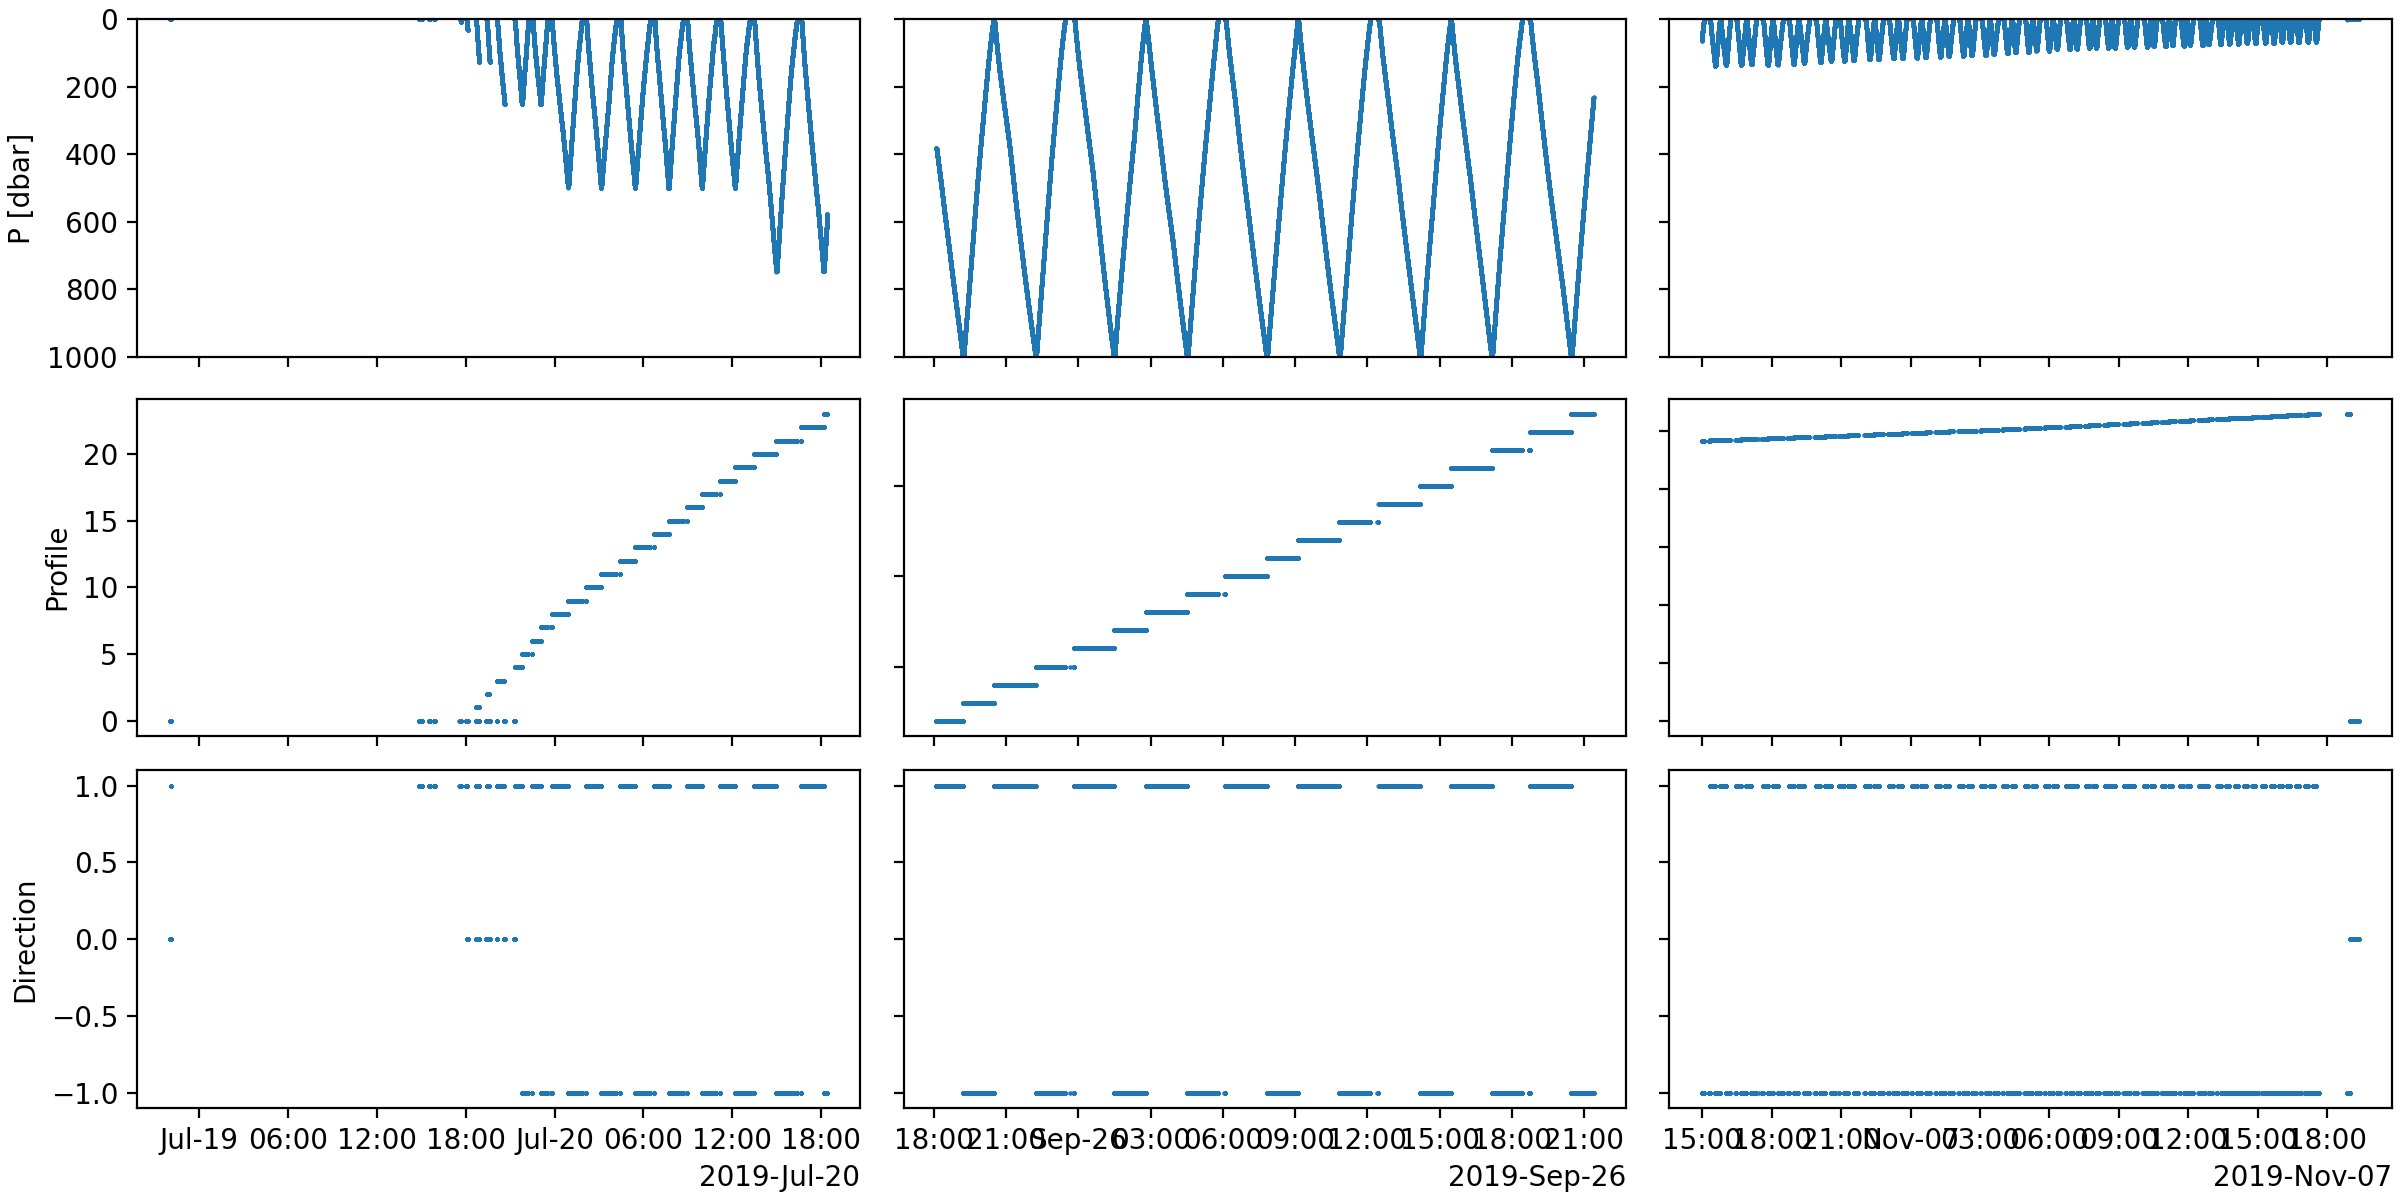

In [8]:
def plot_profiles(fname, plotname):

    with xr.open_dataset(fname) as ds0:
        N = len(ds0.time)
        print(N)
        todo = [slice(0, 70000), slice(int(N/2), int(N/2)+70000), slice(-70000, -1),]
        fig, axs = plt.subplots(nrows=3, ncols=3, constrained_layout=True, figsize=(12, 6))

        for nn, td in enumerate(todo):
            ds = ds0.isel(time=td)
            axs[0, nn].plot(ds.time, ds.pressure, '.', markersize=1)
            axs[0, nn].set_ylim([1000, 0])
            if nn==0:
                axs[0, nn].set_ylabel('P [dbar]')
            else:
                axs[0, nn].set_yticklabels('')
            axs[0, nn].set_xticklabels('')
   
            axs[1, nn].plot(ds.time, ds.profile_index, '.', markersize=1)
            if nn==0:
                axs[1, nn].set_ylabel('Profile')
            else:
                axs[1, nn].set_yticklabels('')
            axs[1, nn].set_xticklabels('')

            axs[2, nn].plot(ds.time, ds.profile_direction, '.', markersize=1)
            if nn==0:
                axs[2, nn].set_ylabel('Direction')
            else:
                axs[2, nn].set_yticklabels('')


            plt.show()
    fig.savefig(plotname)
            
plot_profiles(f'L0-timeseries/{deploy_name}_L0.nc', 'figs/ProfileCheck.png')


## T/C offset

Check if there should be a time offset applied to the conductivity cell to match the temperature.

From the plot below, we see that there is a slight up/down asymmetry, with the profiles saltier on the way down (profile 100 and 102) than on the way up, particularly right near the seasonal thermocline.  This really isn't too bad, but lets try and fix.

This CTD is pumped, however, so the lags are nowhere near as bad as other glider CTDs.  The evidence below is that perhaps a half-second delay will improve the match near the surface, but adding that delay makes the profile more variable at deeper depths, so the advantage is quite minimal.  Note the tightness of the deep T/S curves, so overall this CTD is doing quite a good job.

<IPython.core.display.Javascript object>


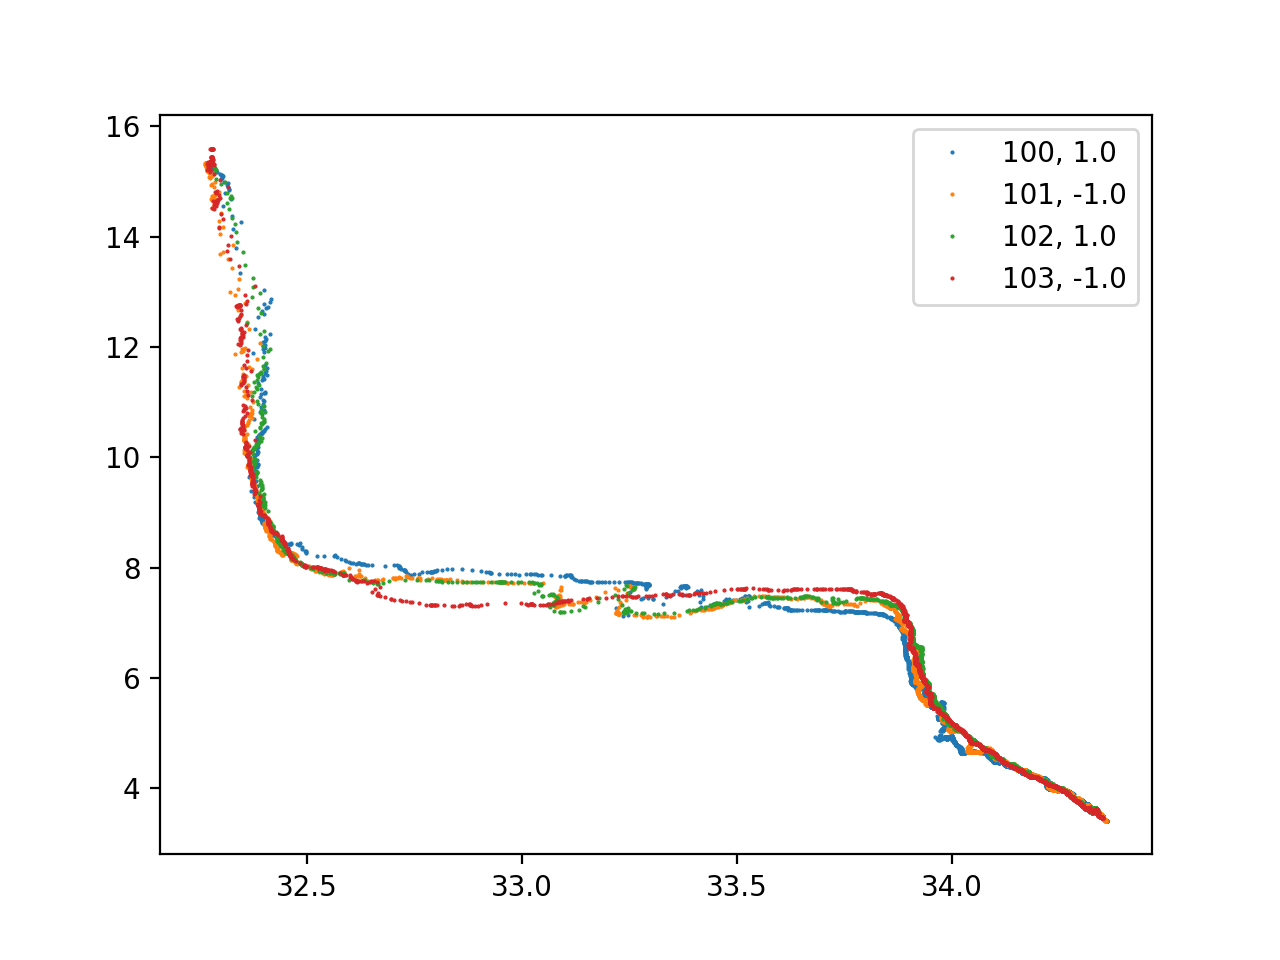

In [68]:
with xr.open_dataset(f'L0-timeseries/{deploy_name}_L0.nc') as ds0:
    fig, ax = plt.subplots()

    for td in range(100, 104):
        
        ds = ds0.where(ds0['profile_index']==td, drop=True)
        ax.plot(ds.salinity, ds.temperature, '.', markersize=1, label=f'{td}, {ds.profile_direction[10].values}' )
    ax.legend()

<IPython.core.display.Javascript object>


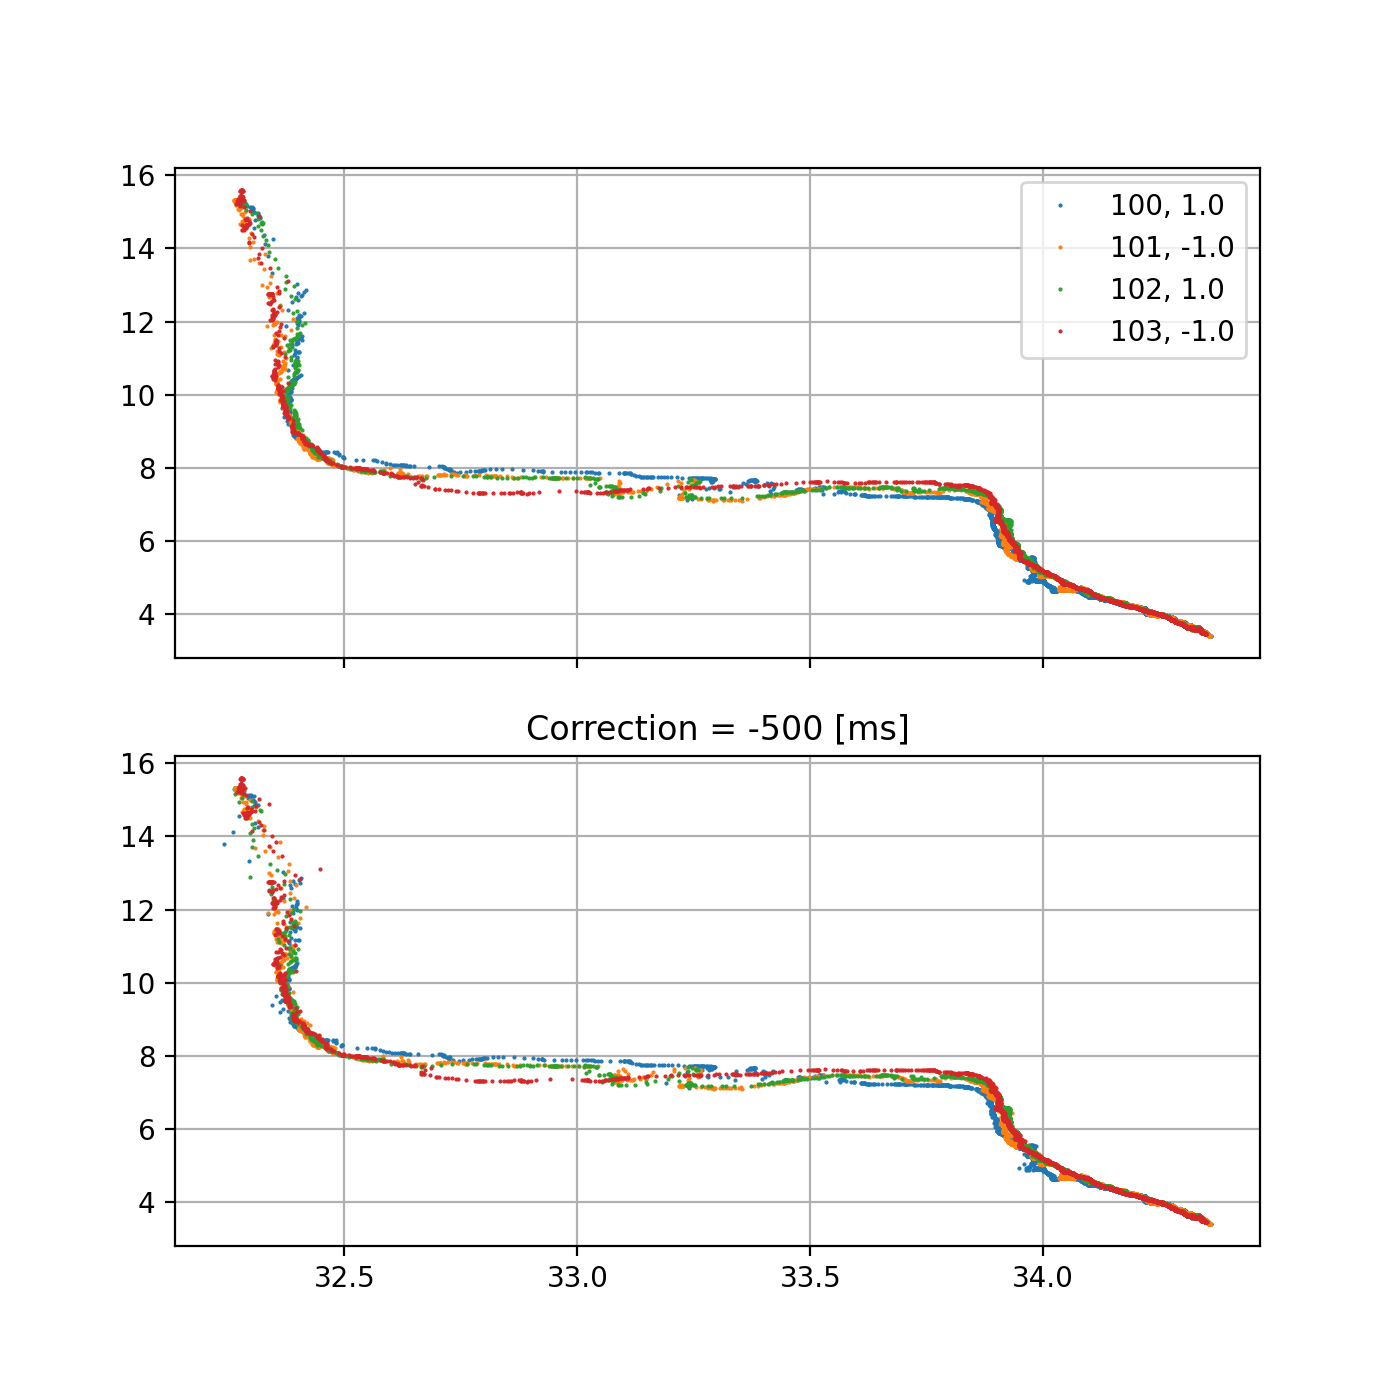

In [69]:
with xr.open_dataset(f'L0-timeseries/{deploy_name}_L0.nc') as ds0:
    fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(7, 7))

    for td in range(100, 104):
        
        ds = ds0.where(ds0['profile_index']==td, drop=True)
        good = np.where(np.isfinite(ds.conductivity.values))[0]
        corr = -500
        ds['new_conductivity']= np.interp(ds.time, ds.time[good]+np.timedelta64(corr, 'ms'), ds.conductivity[good])
        ds['new_salinity'] = seawater.eos80.salt(ds['new_conductivity'] / seawater.constants.c3515 * 10, ds.temperature, ds.pressure)
        axs[0].plot(ds.salinity, ds.temperature, '.', markersize=1, label=f'{td}, {ds.profile_direction[10].values}' )
        axs[1].set_title(f'Correction = {corr} [ms]')
        axs[1].plot(ds.new_salinity, ds.temperature, '.', markersize=1, label=f'{td}, {ds.profile_direction[10].values}' )
        axs[0].grid(True)

        axs[1].grid(True)

    axs[0].legend()

<IPython.core.display.Javascript object>


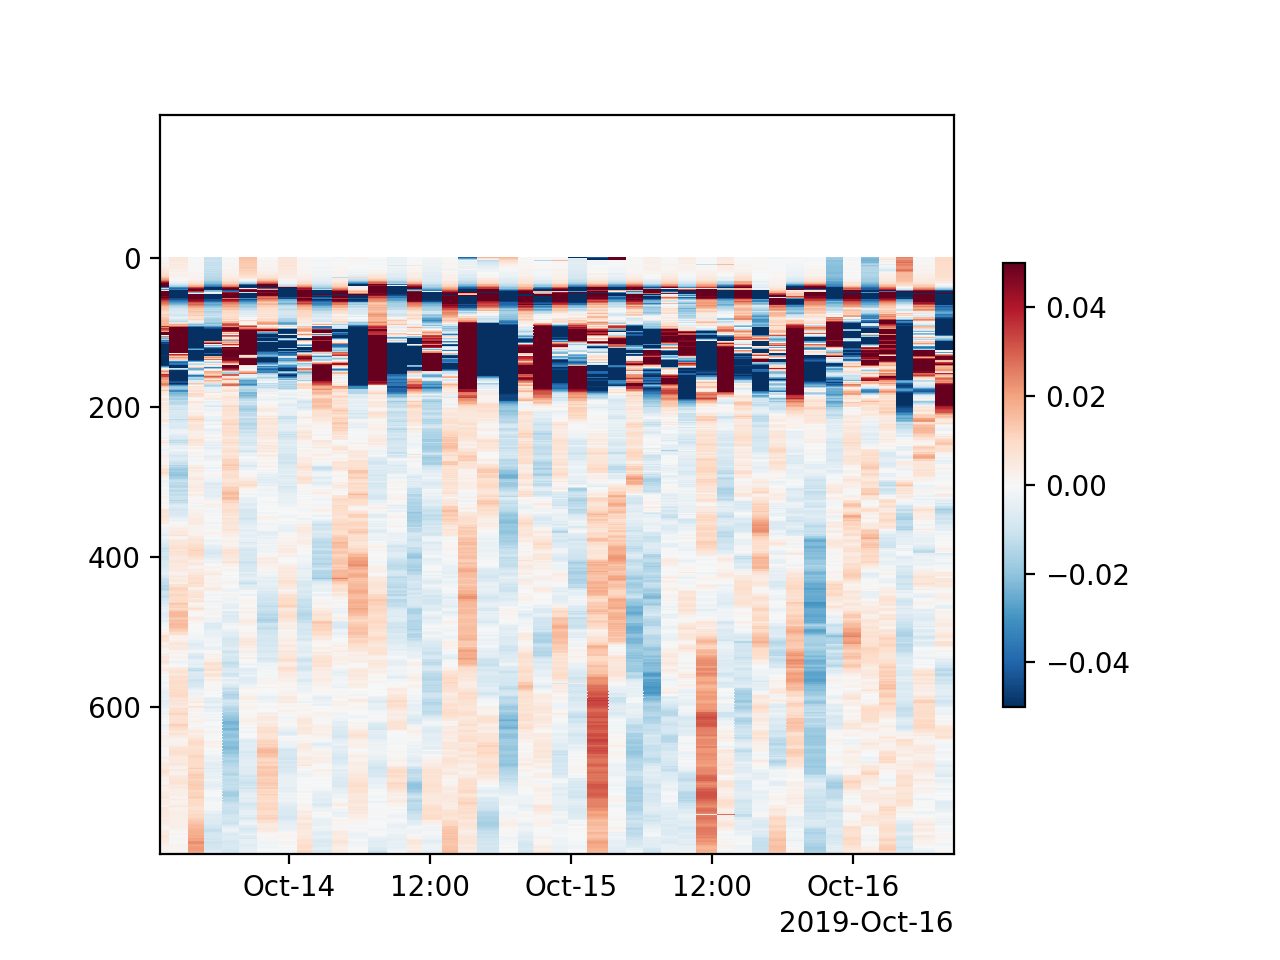

<xarray.DataArray 'density' (depth: 1100, time: 1326)>
[1458600 values with dtype=float64]
Coordinates:
  * depth    (depth) float64 0.5 1.5 2.5 3.5 ... 1.098e+03 1.098e+03 1.1e+03
    profile  (time) float64 ...
  * time     (time) datetime64[ns] 2019-07-19T18:46:46.751708160 ... 2019-11-07T18:14:00.561308672
Attributes:
    long_name:            Density
    standard_name:        sea_water_density
    units:                kg m-3
    comment:              raw, uncorrected salinity
    observation_type:     calulated
    sources:              salinity temperature pressure
    instrument:           instrument_ctd
    method:               get_derived_eos_raw
    valid_min:            1000.0
    valid_max:            1040.0
    accuracy:             0.01
    precision:            0.01
    resolution:           0.001
    platform:             platform
    ancillary_variables:   


In [156]:
with xr.open_dataset('L0-gridfiles/dfo-walle652-20190718_grid.nc') as ds:
    fig, ax = plt.subplots()
    pcm = ax.pcolormesh(ds['time'], ds['depth'], ds['salinity'].diff(dim='time'), 
                        rasterized=True, vmin=-0.1/2, vmax=0.1/2, cmap='RdBu_r')
    fig.colorbar(pcm, shrink=0.6)
    ax.set_ylim([1000, 0])
    print(ds['density'])

<IPython.core.display.Javascript object>


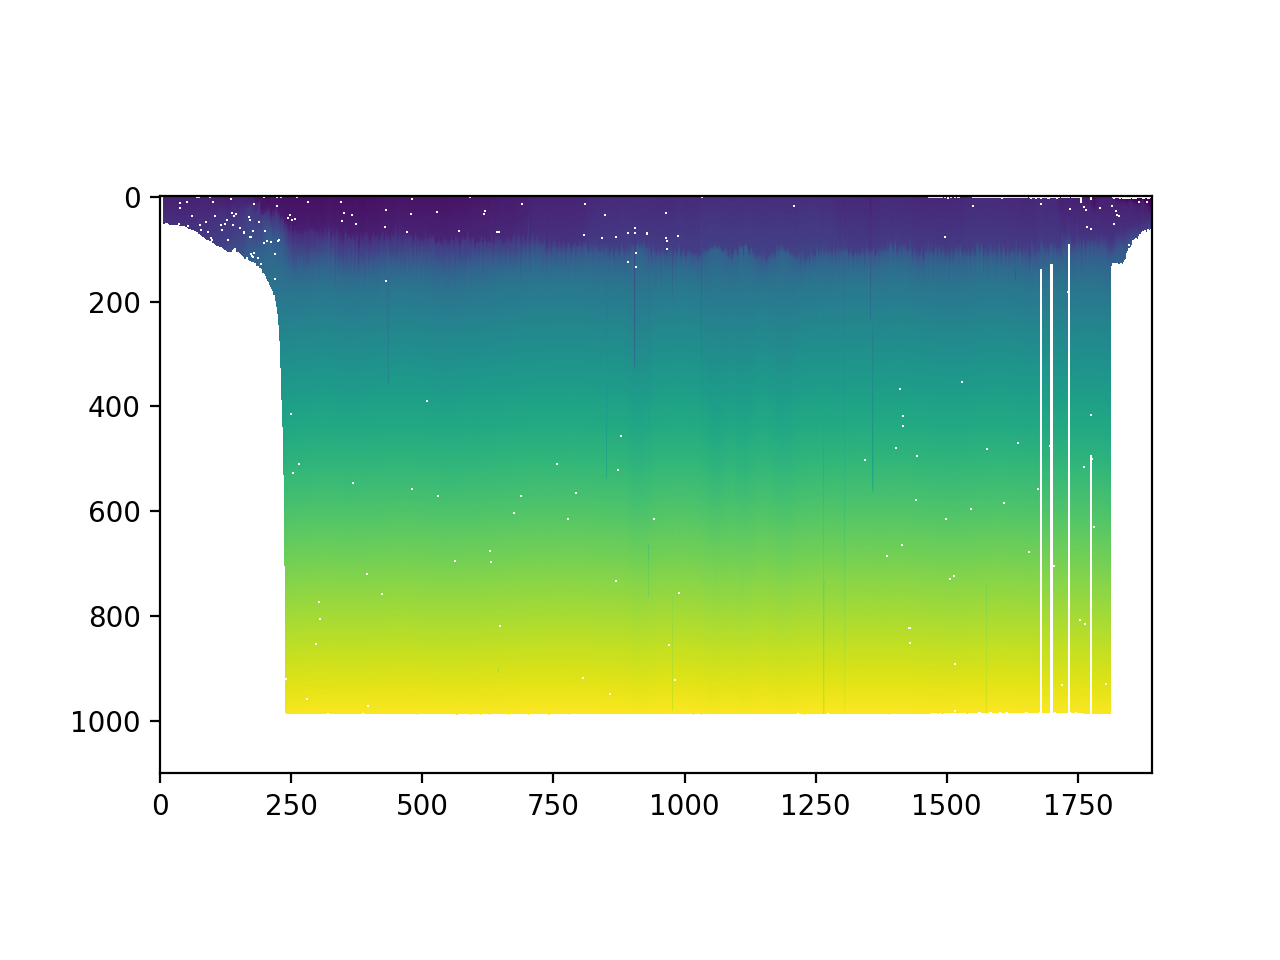

In [41]:
with xr.open_dataset('../dfo-walle652-20191209/L0-gridfiles/dfo-walle652-20191209_grid.nc') as ds:
    fig, ax = plt.subplots()
#    ax.pcolormesh(ds['time'], ds['depth'], ds['density'], rasterized=True)

    ax.imshow(ds['density'])





<IPython.core.display.Javascript object>


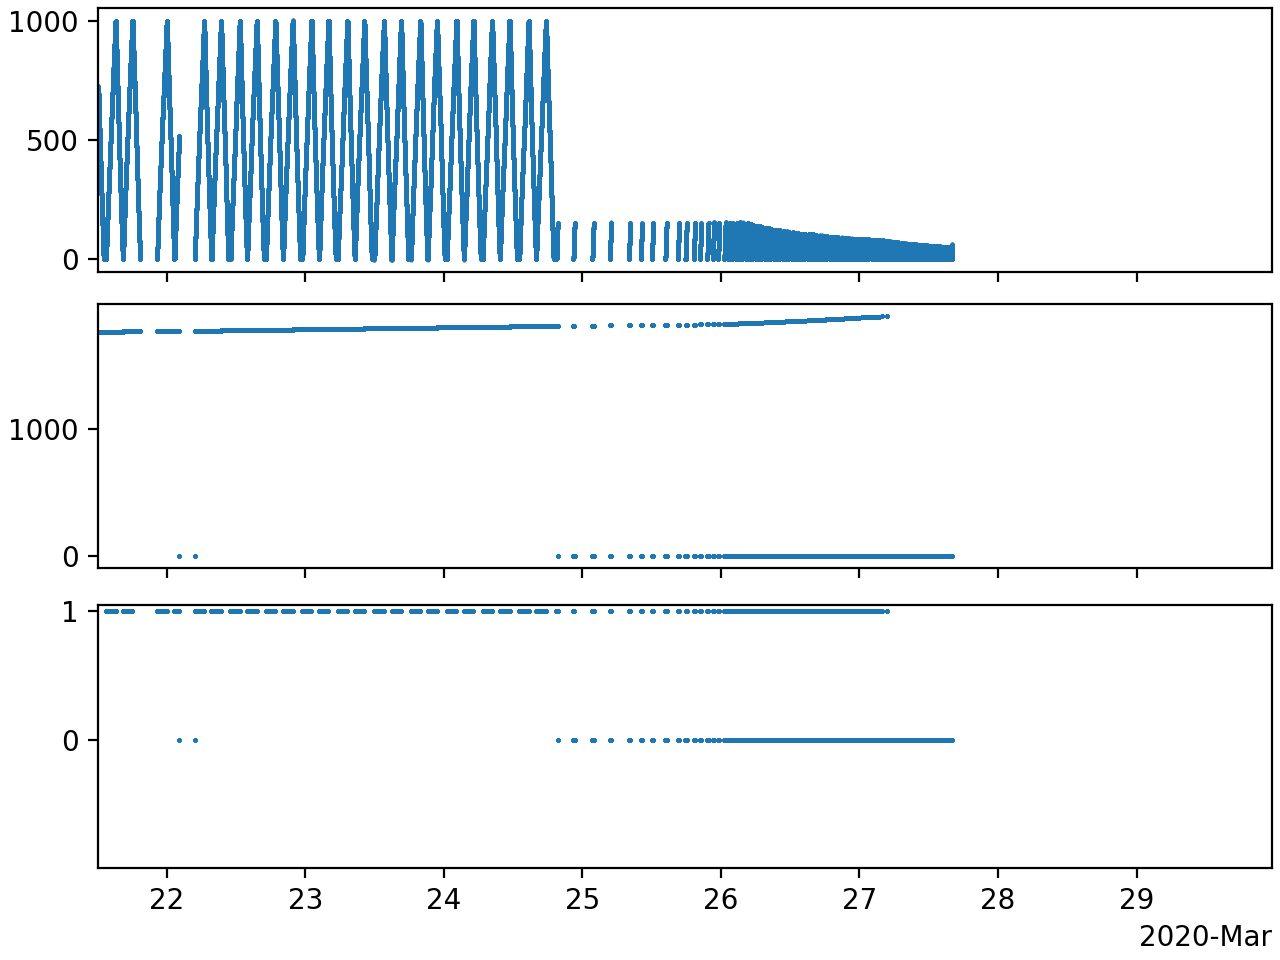

Done???


In [39]:
import pyglider.slocum as slocum
import pyglider.utils as utils
from scipy.signal import argrelextrema

with xr.open_dataset('../dfo-walle652-20191209/L0-timeseries/dfo-walle652-20191209_L0.nc') as ds:
    fig, axs = plt.subplots(nrows=3, ncols=1, constrained_layout=True, sharex=True)
    # ds = ds.isel(time=range(400000, 5000000))
    if 0:
        good = np.where(np.isfinite(ds.pressure))[0]
        filt_length = 30
        filt_length = int(filt_length * float(np.diff(ds.time.values).mean())/1e9 )
        print()
        p = np.convolve(ds.pressure.values[good],
                        np.ones(filt_length) / filt_length, 'same')
        pp = p[::10]

        maxs = argrelextrema(pp, np.greater)[0]
        mins = argrelextrema(pp, np.less)[0]
        maxs = good[maxs * 10]
        mins = good[mins * 10]
        mins = np.concatenate(([0], mins, good[[-1]]))

        print(mins)
        pronum = 1
        profile = ds.pressure.values * 0
        direction = ds.pressure.values * 0
        for n, i in enumerate(mins[:-1]):
            # down
            try:

                print(n, mins[[n, n+1]], maxs[[n, n+1]])
                profile[mins[n]:maxs[n]+1] = pronum
                direction[mins[n]:maxs[n]+1] = +1
                pronum += 1
                # up
                profile[maxs[n]:mins[n+1]+1] = pronum
                direction[maxs[n]:mins[n+1]+1] = -1
                pronum += 1
            except:
                print('Failed?')
    
    #ds = utils.get_profiles_new(ds,
    #            filt_time=100, profile_min_time=400)
    print('Done???')
    
    axs[0].plot(ds['time'], ds['pressure'], '.', markersize=1)

    axs[0].plot(ds['time'][good], p, 'r.', markersize=1)

    axs[0].plot(ds['time'][mins], ds['pressure'][mins], 'g.', markersize=5)

    axs[0].plot(ds['time'][maxs], ds['pressure'][maxs], 'b.', markersize=5)


    axs[1].plot(ds['time'], ds['profile_index'], '.', markersize=1)
    axs[2].plot(ds['time'], ds['profile_direction'], '.', markersize=1)
    pri

<xarray.Dataset>
Dimensions:                (time: 7230199)
Coordinates:
  * time                   (time) datetime64[ns] 2019-12-09T17:36:04.936614912 ... 2020-03-27T16:02:35.367553792
    latitude               (time) float64 ...
    longitude              (time) float64 ...
    depth                  (time) float64 ...
Data variables:
    heading                (time) float64 ...
    pitch                  (time) float64 ...
    roll                   (time) float64 ...
    waypoint_latitude      (time) float64 ...
    waypoint_longitude     (time) float64 ...
    conductivity           (time) float64 ...
    temperature            (time) float64 ...
    pressure               (time) float64 -0.08 nan nan nan ... nan 63.06 nan
    chlorophyll            (time) float64 ...
    cdom                   (time) float64 ...
    backscatter_700        (time) float64 ...
    oxygen_concentration   (time) float64 ...
    distance_over_ground   (time) float64 ...
    profile_index          (ti

## Add data_mode to files...

In [53]:
import os
td = ['../dfo-walle652-20191209/L0-gridfiles/dfo-walle652-20191209_grid.nc', 
      '../dfo-walle652-20191209/L0-timeseries/dfo-walle652-20191209_L0.nc',
      '../dfo-walle652-20190718/L0-gridfiles/dfo-walle652-20190718_grid.nc', 
      '../dfo-walle652-20190718/L0-timeseries/dfo-walle652-20190718_L0.nc',
     ]
for fn in td:
    with xr.open_dataset(fn) as ds:
        ds.attrs['data_mode'] = 'P'
        ds.to_netcdf('tmp.nc')
    os.system(f'mv tmp.nc {fn}')


In [54]:
with xr.open_dataset(fn) as ds:
    print(ds)

<xarray.Dataset>
Dimensions:                   (time: 5497225)
Coordinates:
  * time                      (time) datetime64[ns] 2019-07-18T22:01:26.593933056 ... 2019-11-07T19:22:23.462432768
    latitude                  (time) float64 ...
    longitude                 (time) float64 ...
    depth                     (time) float64 ...
Data variables:
    heading                   (time) float64 ...
    pitch                     (time) float64 ...
    roll                      (time) float64 ...
    waypoint_latitude         (time) float64 ...
    waypoint_longitude        (time) float64 ...
    conductivity              (time) float64 ...
    temperature               (time) float64 ...
    pressure                  (time) float64 ...
    chlorophyll               (time) float64 ...
    cdom                      (time) float64 ...
    backscatter_700           (time) float64 ...
    oxygen_concentration      (time) float64 ...
    oxygen_saturation         (time) float64 ...
    temp

## Check up/down

<IPython.core.display.Javascript object>


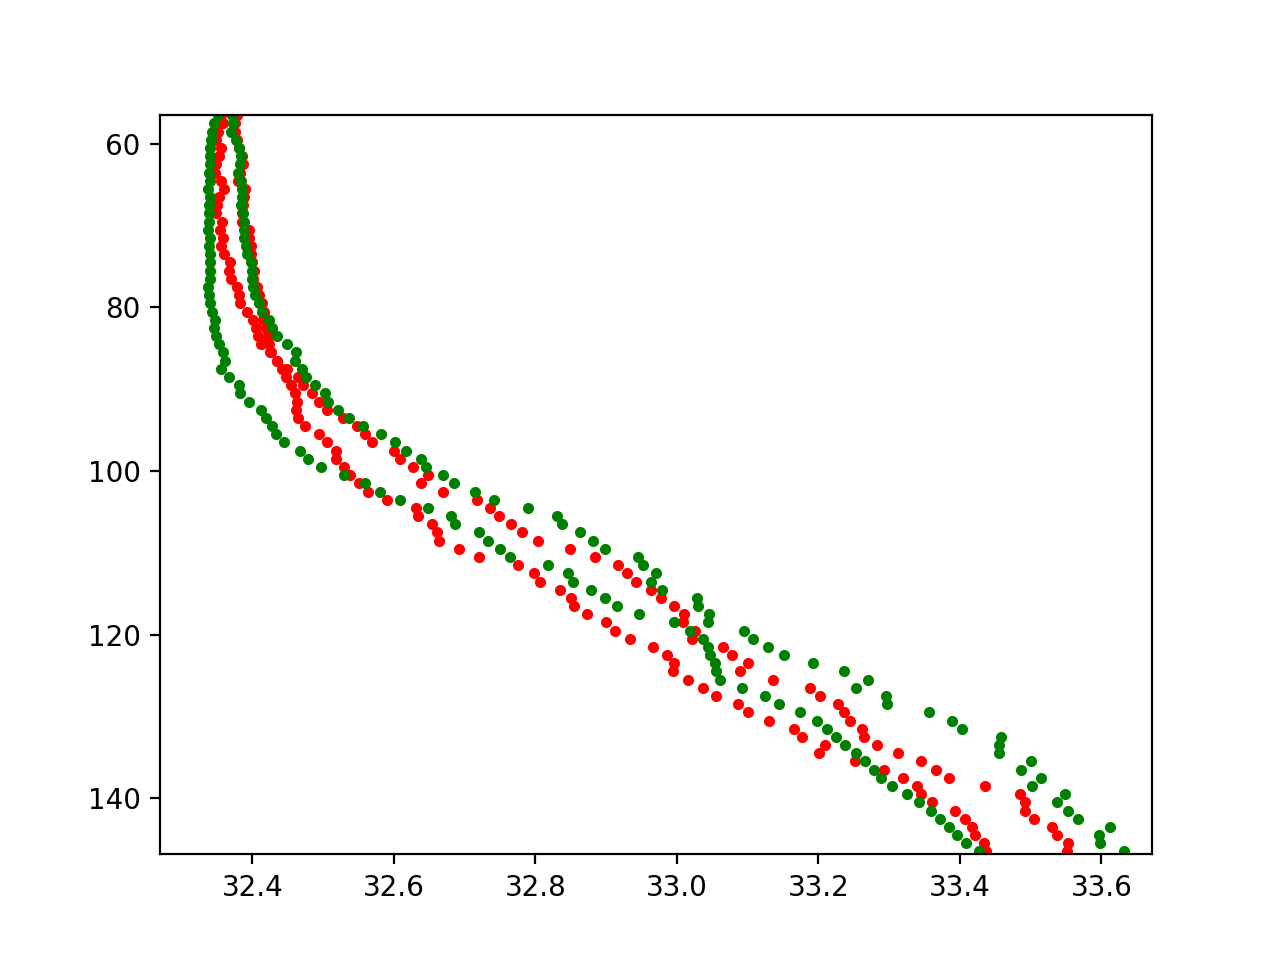

In [62]:
with xr.open_dataset('L0-gridfiles/dfo-walle652-20190718_grid.nc') as ds:
    fig, axs = plt.subplots()
    
    axs.plot(ds.salinity[:, 100:104:2], ds.depth,  '.r')

    axs.plot(ds.salinity[:, 101:104:2], ds.depth,  '.g')

    axs.set_ylim([200, 0])

<IPython.core.display.Javascript object>


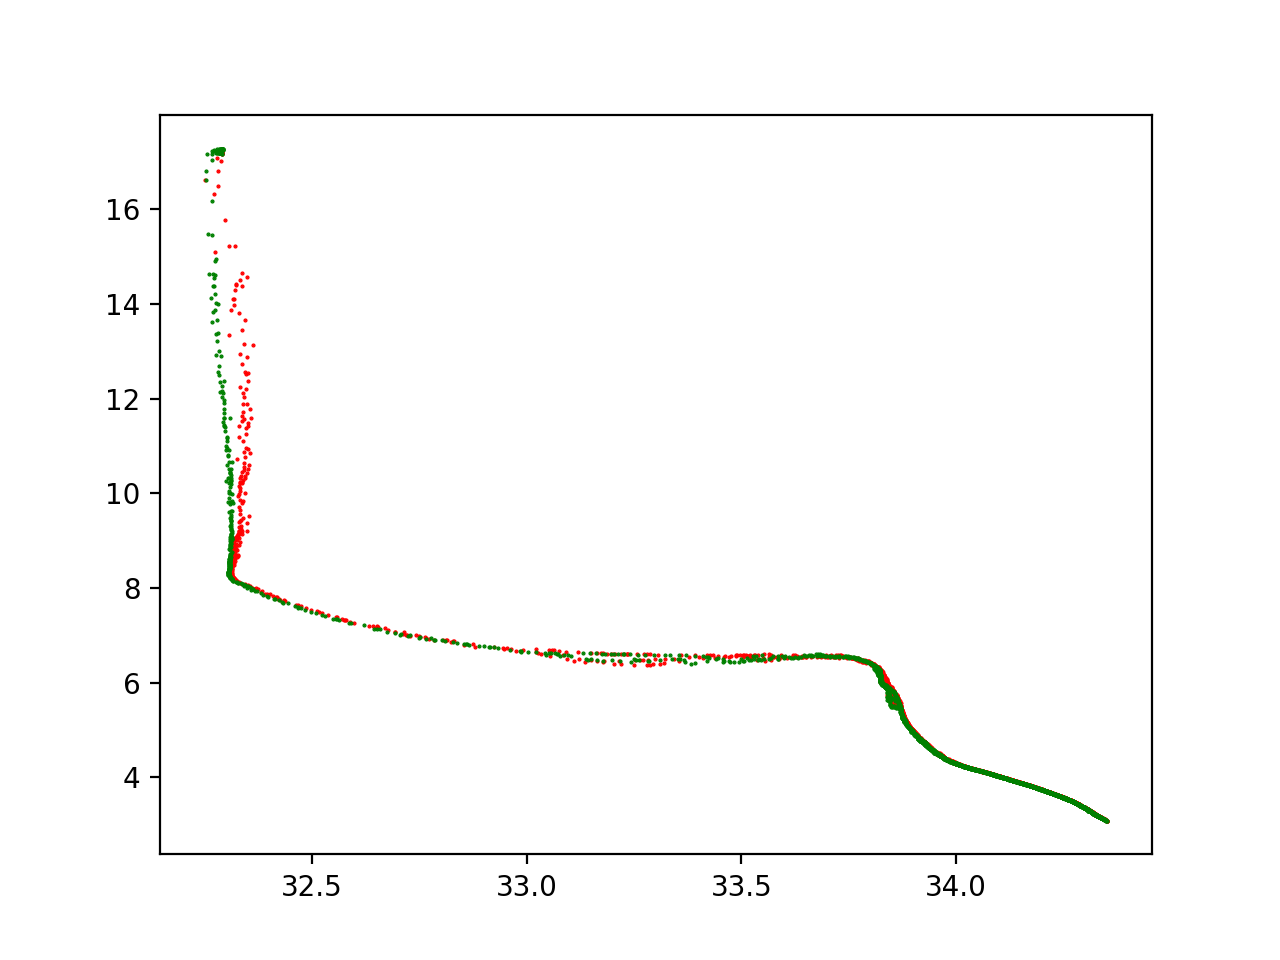

In [183]:
ind = 300
with xr.open_dataset('L0-gridfiles/dfo-walle652-20190718_grid.nc') as ds:
    fig, axs = plt.subplots()
    
    axs.plot(ds.salinity[:, ind + np.arange(0, 6, 2)], ds.temperature[:, ind + np.arange(0, 6, 2)],  '.r', markersize=1)

    axs.plot(ds.salinity[:, ind + np.arange(1, 6, 2)], ds.temperature[:, ind + np.arange(1, 6, 2)],  '.g', markersize=1)

#    axs.set_ylim([200, 0])
#    axs.set_ylim([4, 8])
#    axs.set_xlim([33.2, 34.2])

<IPython.core.display.Javascript object>


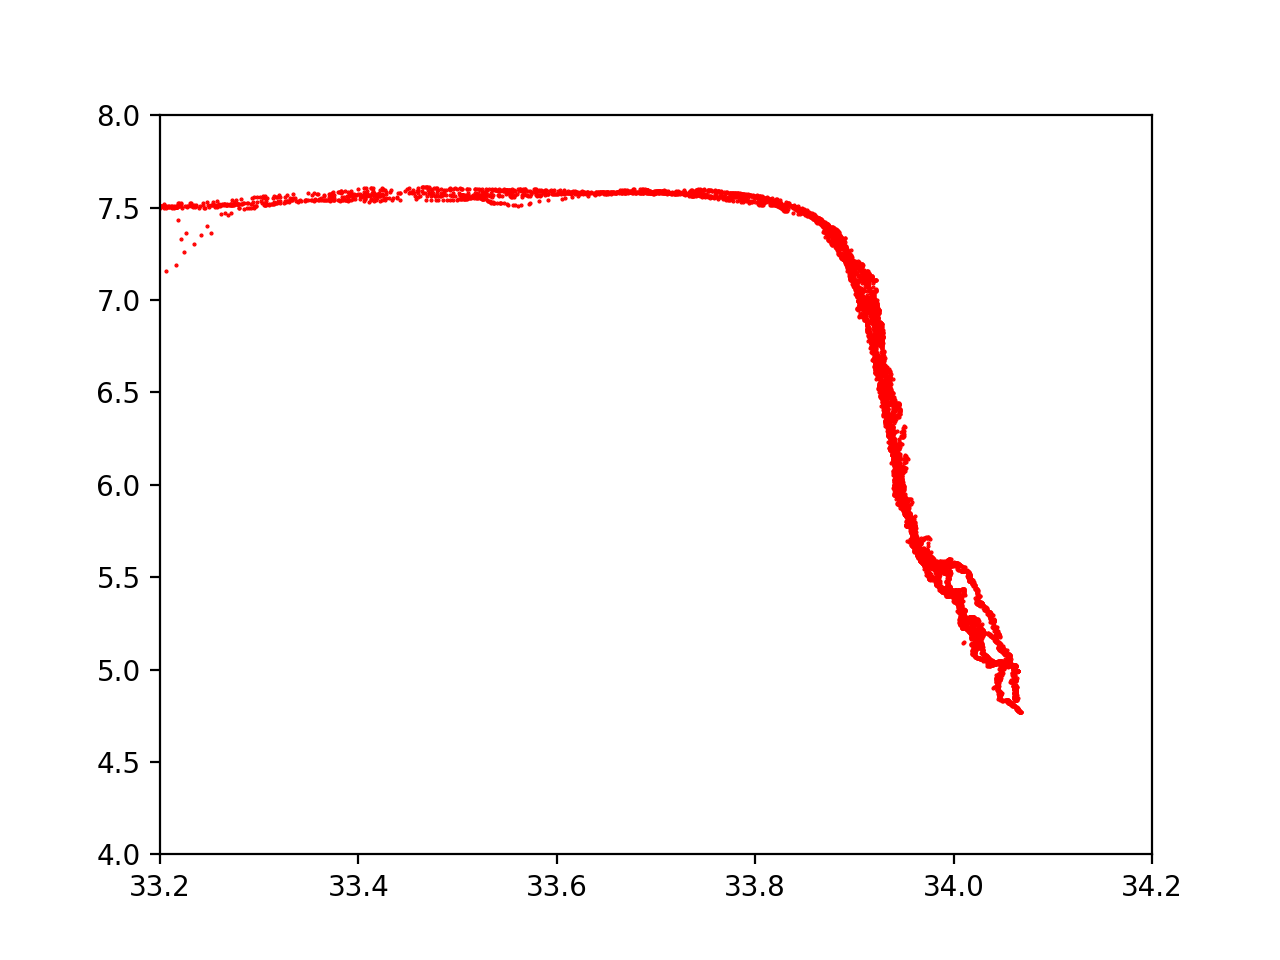

<xarray.DataArray 'profile_direction' ()>
array(30000)
<xarray.DataArray 'profile_direction' ()>
array(0)


In [79]:
ind = 300
with xr.open_dataset('L0-timeseries/dfo-walle652-20190718_L0.nc') as ds:
    ds = ds.isel(time=slice(10000, 40000))
    fig, axs = plt.subplots()
    
    print(np.sum(ds.profile_direction>0))
    axs.plot(ds.salinity[ds.profile_direction>0], ds.temperature[ds.profile_direction>0],  '.r', markersize=1)
    print(np.sum(ds.profile_direction<0))


    axs.plot(ds.salinity[ds.profile_direction<0], ds.temperature[ds.profile_direction<0],  '.g', markersize=1)


#    axs.plot(ds.salinity, ds.temperature,  '.g', markersize=1)

#    axs.set_ylim([200, 0])
    axs.set_ylim([4, 8])
    axs.set_xlim([33.2, 34.2])

<IPython.core.display.Javascript object>


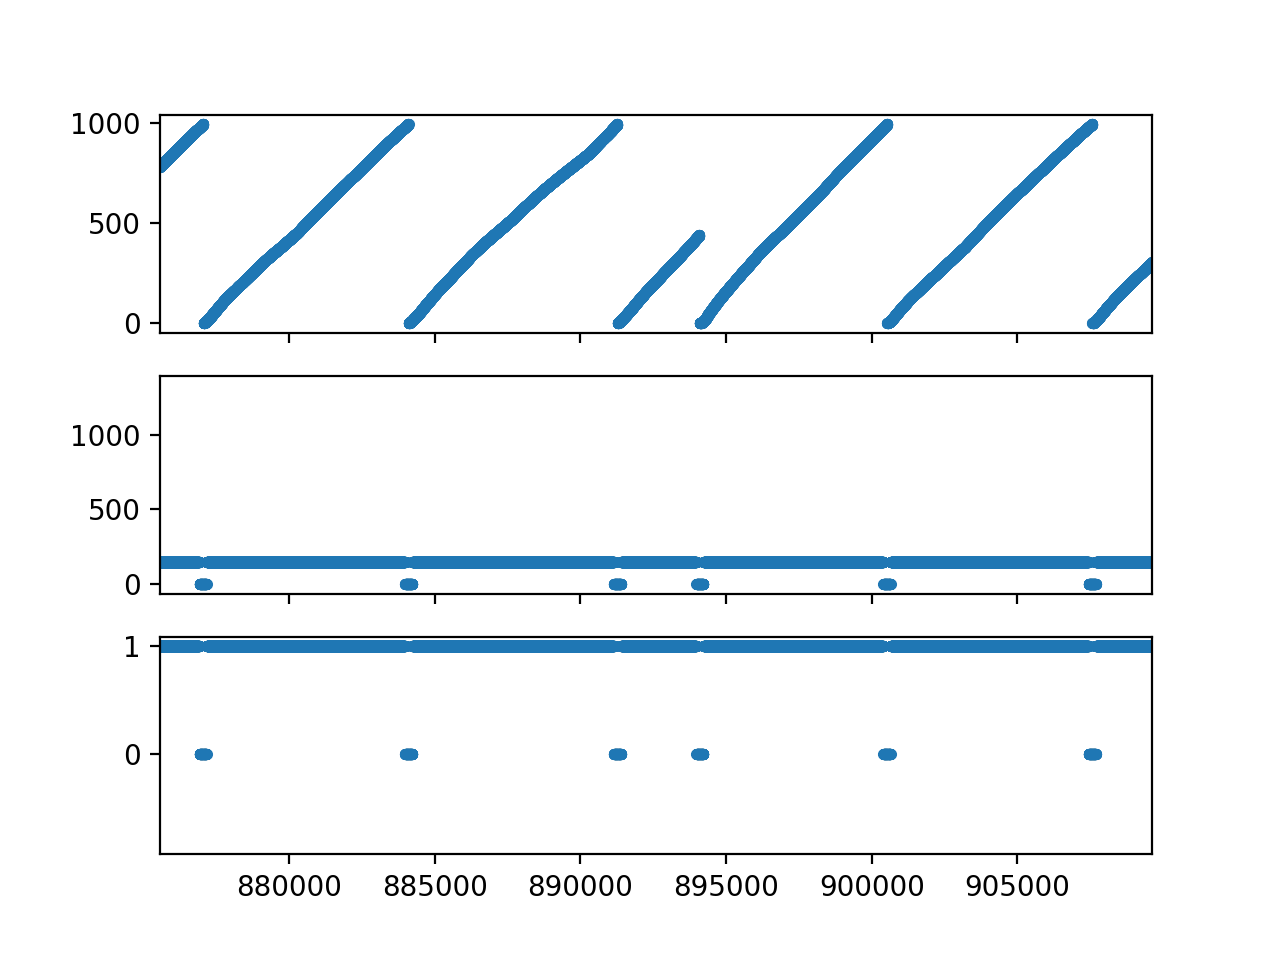

In [111]:
import logging 
logging.basicConfig(level=logging.INFO)
with xr.open_dataset('L0-timeseries/dfo-walle652-20190718_L0.nc') as ds:
    
    #ds = ds.isel(time=slice(0, 240000))
    #ds = utils.get_profiles_new(ds)
    fig, axs = plt.subplots(nrows=3, sharex=True)
    
    axs[0].plot(ds.pressure, '.')    
    axs[1].plot(ds.profile_index, '.')
    axs[2].plot(ds.profile_direction, '.')

<IPython.core.display.Javascript object>


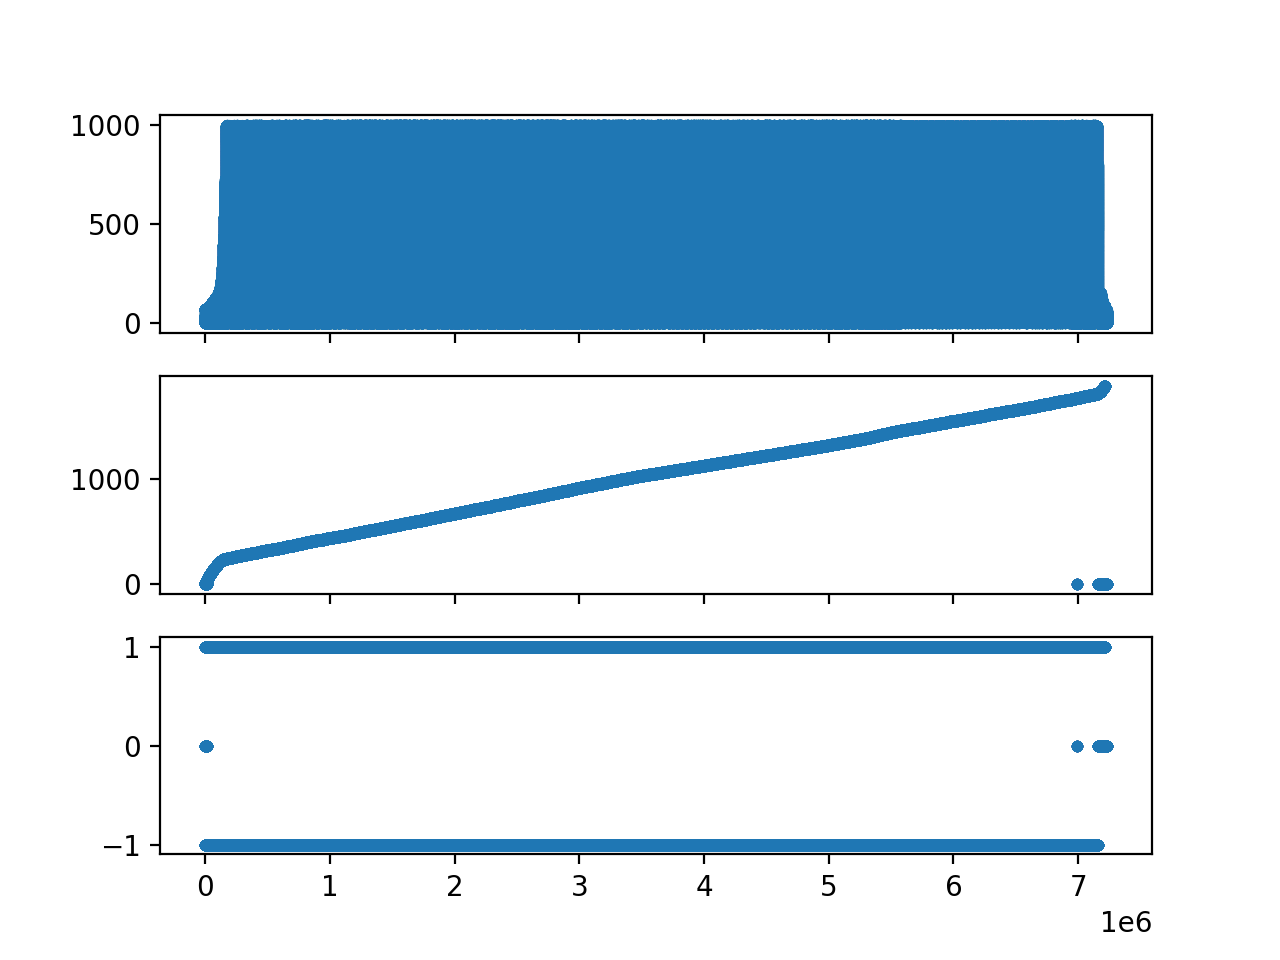

In [112]:
import logging 
logging.basicConfig(level=logging.INFO)
with xr.open_dataset('../dfo-walle652-20191209/L0-timeseries/dfo-walle652-20191209_L0.nc') as ds:
    
    #ds = ds.isel(time=slice(0, 240000))
    #ds = utils.get_profiles_new(ds)
    fig, axs = plt.subplots(nrows=3, sharex=True)
    
    axs[0].plot(ds.pressure, '.')    
    axs[1].plot(ds.profile_index, '.')
    axs[2].plot(ds.profile_direction, '.')

In [115]:
with xr.open_dataset('../dfo-walle652-20190718/L0-gridfiles/dfo-walle652-20190718_grid.nc') as ds:
    print(ds)


<xarray.Dataset>
Dimensions:                (depth: 1100, time: 1326)
Coordinates:
  * depth                  (depth) float64 0.5 1.5 2.5 ... 1.098e+03 1.1e+03
    profile                (time) float64 ...
  * time                   (time) datetime64[ns] 2019-07-19T18:46:46.751708160 ... 2019-11-07T18:14:00.561308672
Data variables:
    longitude              (time) float64 ...
    latitude               (time) float64 ...
    profile_time_start     (time) datetime64[ns] ...
    profile_time_end       (time) datetime64[ns] ...
    heading                (depth, time) float64 ...
    pitch                  (depth, time) float64 ...
    roll                   (depth, time) float64 ...
    waypoint_latitude      (depth, time) float64 ...
    waypoint_longitude     (depth, time) float64 ...
    conductivity           (depth, time) float64 ...
    temperature            (depth, time) float64 ...
    pressure               (depth, time) float64 ...
    chlorophyll            (depth, time) fl